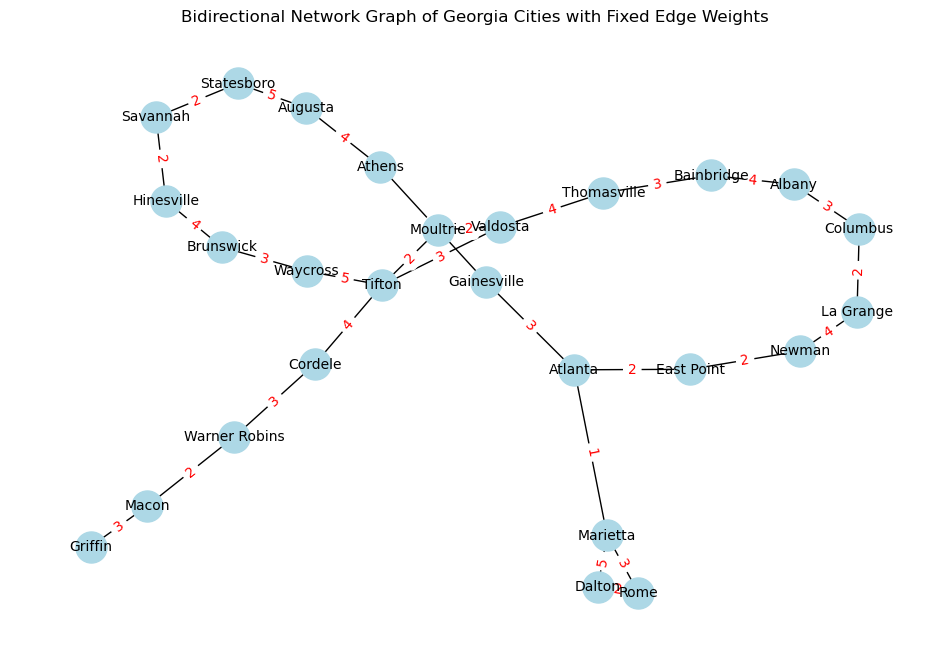

In [30]:
# First, we need to import the required libraries
import matplotlib.pyplot as plt
import networkx as nx

# Define fixed weights for edges
fixed_weights = {
    ('Dalton', 'Rome'): 2,
    ('Dalton', 'Marietta'): 5,
    ('Rome', 'Marietta'): 3,
    ('Marietta', 'Atlanta'): 1,
    ('Atlanta', 'East Point'): 2,
    ('Atlanta', 'Gainesville'): 3,
    ('East Point', 'Newman'): 2,
    ('Newman', 'La Grange'): 4,
    ('La Grange', 'Columbus'): 2,
    ('Columbus', 'Albany'): 3,
    ('Albany', 'Bainbridge'): 4,
    ('Gainesville', 'Athens'): 2,
    ('Athens', 'Augusta'): 4,
    ('Augusta', 'Statesboro'): 5,
    ('Statesboro', 'Savannah'): 2,
    ('Griffin', 'Macon'): 3,
    ('Macon', 'Warner Robins'): 2,
    ('Warner Robins', 'Cordele'): 3,
    ('Cordele', 'Tifton'): 4,
    ('Tifton', 'Valdosta'): 3,
    ('Valdosta', 'Thomasville'): 4,
    ('Thomasville', 'Bainbridge'): 3,
    ('Moultrie', 'Tifton'): 2,
    ('Moultrie', 'Valdosta'): 2,
    ('Waycross', 'Brunswick'): 3,
    ('Brunswick', 'Hinesville'): 4,
    ('Hinesville', 'Savannah'): 2,
    ('Waycross', 'Tifton'): 5
}

# Create a graph
G = nx.Graph()

# Add edges with fixed weights
for (city1, city2), weight in fixed_weights.items():
    G.add_edge(city1, city2, weight=weight)

# Now let's draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Position nodes for better visualization

# Drawing the nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue")

# Drawing the labels for the nodes
nx.draw_networkx_labels(G, pos, font_size=10)

# Drawing the edges with arrows
nx.draw_networkx_edges(G, pos, arrows=True)

# Extracting edge labels for fixed weights
edge_labels = nx.get_edge_attributes(G, 'weight')

# Drawing the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Setting the title and turning off the axis
plt.title("Bidirectional Network Graph of Georgia Cities with Fixed Edge Weights")
plt.axis('off')  # Hide the axis for a cleaner look

# Display the graph
plt.show()


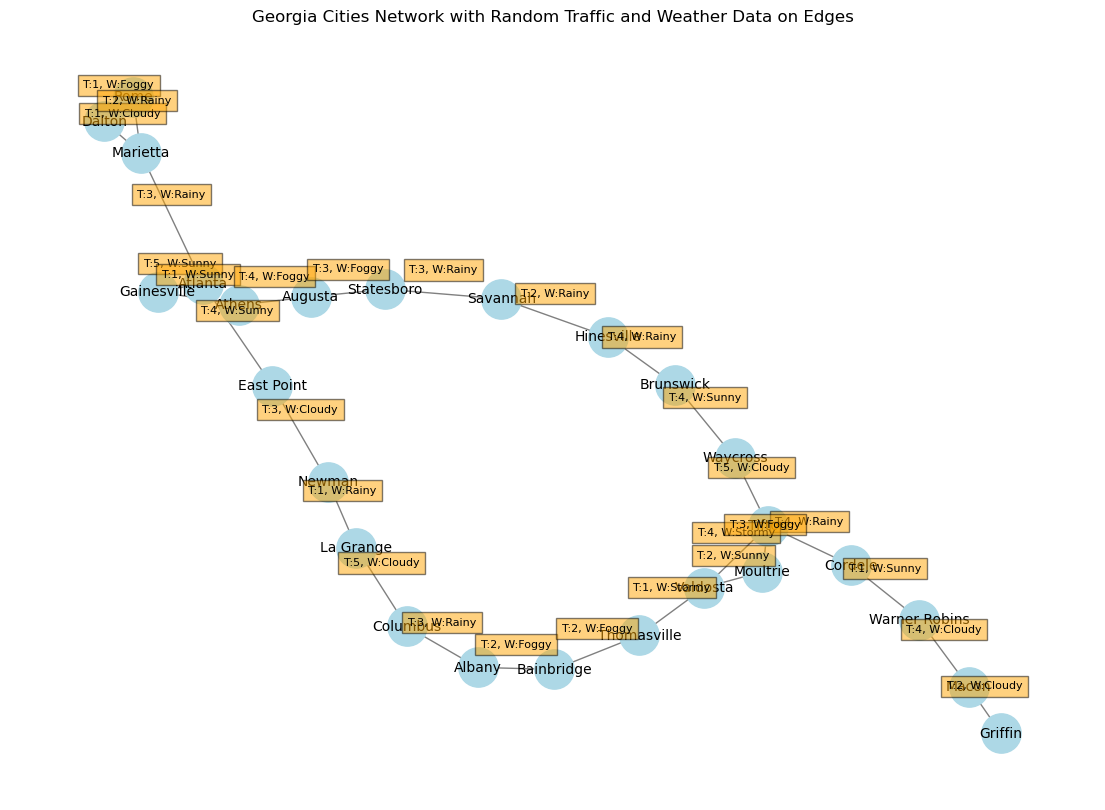

In [18]:
import hashlib
import random
import heapq

def serialize_conditions(conditions):
    # Sort the conditions to ensure consistent ordering
    sorted_conditions = sorted(conditions.items())
    # Create a string representation
    conditions_str = ",".join(f"{u}{v}{traffic}{weather}" for (u, v), (traffic, weather) in sorted_conditions)
    return conditions_str

def generate_conditions_hash(conditions):
    conditions_str = serialize_conditions(conditions)
    # Encode the string to a bytes object as hashlib requires bytes-like object
    conditions_bytes = conditions_str.encode()
    # Generate SHA-256 hash
    hash_obj = hashlib.sha256(conditions_bytes)
    # Return the hexadecimal representation of the hash
    return hash_obj.hexdigest()

def draw_graph_with_conditions_and_return():
    # Apply random traffic and weather conditions to each edge in the graph
    for u, v in G.edges():
        G[u][v]['traffic'] = random.randint(1, 5)
        G[u][v]['weather'] = random.choice(['Sunny', 'Rainy', 'Cloudy', 'Stormy', 'Foggy'])
    
    # Draw the graph
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color="lightblue")
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, edge_color='grey')
    
    # Prepare conditions for hash generation and annotations
    conditions = {}
    for edge in G.edges():
        traffic = G[edge[0]][edge[1]]['traffic']
        weather = G[edge[0]][edge[1]]['weather']
        conditions[edge] = (traffic, weather)
        
        # Calculate edge center for annotation placement
        edge_center = [(pos[edge[0]][0] + pos[edge[1]][0]) / 2, (pos[edge[0]][1] + pos[edge[1]][1]) / 2]
        plt.text(edge_center[0], edge_center[1] + 0.05, f"T:{traffic}, W:{weather}",
                 horizontalalignment='center', verticalalignment='bottom',
                 bbox=dict(facecolor='orange', alpha=0.5), fontsize=8)
    
    plt.title("Georgia Cities Network with Random Traffic and Weather Data on Edges")
    plt.axis('off')
    plt.show()
    
    # Generate a hash value based on current conditions
    hash_value = generate_conditions_hash(conditions)

    # Return traffic conditions, weather conditions, and the hash value
    traffic_conditions = {edge: G[edge[0]][edge[1]]['traffic'] for edge in G.edges()}
    weather_conditions = {edge: G[edge[0]][edge[1]]['weather'] for edge in G.edges()}
    return traffic_conditions, weather_conditions, hash_value


new_traffic_conditions, new_weather_conditions, hash_value = draw_graph_with_conditions_and_return()

In [28]:

# Implementing the DWTAP algorithm

def calculate_dynamic_weight(u, v, traffic_conditions, weather_data):
    """
    Calculate the dynamic weight for an edge based on refined traffic and weather conditions.
    """
    base_weight = fixed_weights.get((u, v), fixed_weights.get((v, u)))  # Bidirectional support
    traffic_level = traffic_conditions.get((u, v), traffic_conditions.get((v, u), 1))
    weather_condition_u = weather_data.get(u, "Sunny")
    weather_condition_v = weather_data.get(v, "Sunny")

    # Traffic impact: Define a non-linear impact scale for traffic levels
    traffic_impact_scale = {1: 0.05, 2: 0.1, 3: 0.2, 4: 0.4, 5: 0.8}
    traffic_impact = base_weight * traffic_impact_scale[traffic_level]

    # Weather impact: Define specific impacts for different weather conditions
    weather_impact_values = {'Sunny': 0, 'Cloudy': 0.05, 'Rainy': 0.1, 'Stormy': 0.2, 'Foggy': 0.15}
    weather_impact_u = weather_impact_values[weather_condition_u]
    weather_impact_v = weather_impact_values[weather_condition_v]
    weather_impact = base_weight * max(weather_impact_u, weather_impact_v)  # Take the higher impact of the two

    # Calculate dynamic weight
    dynamic_weight = base_weight + traffic_impact + weather_impact
    return dynamic_weight

def dijkstra_manual(G, source, target, traffic_conditions, weather_data):
    """
    Dijkstra's algorithm for finding the shortest path, considering dynamic edge weights.
    """
    Q = []  # Priority queue of (cost, node)
    parents = {node: None for node in G.nodes}  # Parent nodes for path reconstruction
    costs = {node: float('inf') for node in G.nodes}  # Start with infinity costs
    costs[source] = 0  # Cost from source to source is 0
    heapq.heappush(Q, (0, source))  # Push source node into priority queue

    while Q:
        current_cost, current_node = heapq.heappop(Q)
        if current_node == target:
            break  # Stop if target is reached
        
        for neighbor in G.neighbors(current_node):
            weight = calculate_dynamic_weight(current_node, neighbor, traffic_conditions, weather_data)
            new_cost = current_cost + weight
            
            if new_cost < costs[neighbor]:
                costs[neighbor] = new_cost
                parents[neighbor] = current_node
                heapq.heappush(Q, (new_cost, neighbor))
    
    # Reconstruct the shortest path
    path = []
    current = target
    while current is not None:
        path.append(current)
        current = parents[current]
    path.reverse()  # Reverse the path to get the correct order from source to target
    
    return path if path[0] == source else []  # Return the path if it's valid

# Initialize cache for storing paths with their conditions hash
path_cache = {}

In [29]:
def find_or_cache_path(source, destination, conditions_hash, traffic_conditions, weather_data):
    # Check cache for existing path under these conditions
    if conditions_hash in path_cache:
        print("Using cached path for hash :", conditions_hash)
        return path_cache[conditions_hash]
    else:
        # Calculate the path if not found in cache
        path = dijkstra_manual(G, source, destination, traffic_conditions, weather_data)  # Assuming this function exists
        # Cache this new path with the conditions hash
        path_cache[conditions_hash] = path
        print("Calculated and cached new path for hash :", conditions_hash)
        return path

# Example usage: find or use cached path

def display_path_cache(path_cache):
    if(path_cache):
        print()
        print("Existing paths for old weather and traffic conditions")
        print()
            
    for path in path_cache:
        print(path," : ",path_cache[path])
    print("-------------------------------------------------------------------------------------------------------------------------------")

for i in range(5):
    display_path_cache(path_cache)
    source, destination = 'Cordele', 'Valdosta'
    path = find_or_cache_path(source, destination, hash_value, new_traffic_conditions, new_weather_conditions)
    print()
    print(path)


-------------------------------------------------------------------------------------------------------------------------------
Calculated and cached new path for hash : d884caf8aaec59a77f871422ccf62551ac1c0b8a42706b8d7cc0c6ed9b72550a

['Cordele', 'Tifton', 'Valdosta']

Existing paths for old weather and traffic conditions

d884caf8aaec59a77f871422ccf62551ac1c0b8a42706b8d7cc0c6ed9b72550a  :  ['Cordele', 'Tifton', 'Valdosta']
-------------------------------------------------------------------------------------------------------------------------------
Using cached path for hash : d884caf8aaec59a77f871422ccf62551ac1c0b8a42706b8d7cc0c6ed9b72550a

['Cordele', 'Tifton', 'Valdosta']

Existing paths for old weather and traffic conditions

d884caf8aaec59a77f871422ccf62551ac1c0b8a42706b8d7cc0c6ed9b72550a  :  ['Cordele', 'Tifton', 'Valdosta']
-------------------------------------------------------------------------------------------------------------------------------
Using cached path for hash 